In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications.mobilenet import MobileNet

In [2]:
from google.colab import files, drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


### Labeling Dataset based on the Directory Names

In [3]:
datasetDir = '/content/Drive/MyDrive/Dataset'

# get the Subdirectory of the Dataset Folder
for root, folder, files in os.walk(datasetDir):
    if folder != []:
        listDir = folder

classes = []
# retrieve the name and the number of the classification
for i, category in enumerate(listDir):
    # print(category)
    classes.append(category)
    # classes.append({'name' : category,'id' : i + 1, "category" : category})
classes

['Bag',
 'Chair',
 'Cup',
 'Spoon',
 'Fork',
 'Soap',
 'Toothbrush',
 'Pen',
 'Toothpaste',
 'Pencil',
 'Plate',
 'Book',
 'Pencil Case',
 'Eraser',
 'Table']

### Import Dataset

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Create a datagen that is split the dataset into 80% Train and 20% Test
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    shear_range=20,
    zoom_range=0.5,
    width_shift_range=[-0.2, 0.2],
    height_shift_range=[-0.2, 0.2],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
)

# val_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=90,
#     shear_range=20,
#     zoom_range=0.5,
#     width_shift_range=0.5,
#     height_shift_range=0.5,
#     horizontal_flip=True,
#     validation_split=0.2,
# )

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Training Set
training_set = datagen.flow_from_directory(
    datasetDir,
    target_size=(224,224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset="training",
    batch_size=256
)

# Validation Set
validation_set = datagen.flow_from_directory(
    datasetDir,
    target_size=(224,224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    subset="validation",
    batch_size=256
)

# test_set = test_datagen.flow_from_directory(
#     'Test Set',
#     target_size=(224,224),
#     class_mode='categorical',
#     color_mode='rgb',
#     shuffle=True,
#     batch_size=32
# )

Found 2615 images belonging to 15 classes.
Found 647 images belonging to 15 classes.


<h3>Load Model MobileNet</h3>

In [5]:
base_model = MobileNet(weights='imagenet' , include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [6]:
model = tf.keras.models.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  # tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(len(classes) , activation='softmax')
])

In [7]:
for layer in model.layers:
  print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7efe44123090> False
<keras.layers.core.flatten.Flatten object at 0x7efe440c4950> True
<keras.layers.core.dense.Dense object at 0x7efe440c43d0> True


In [8]:
from datetime import datetime

now = datetime.now()
date_string = now.strftime('%d-%m-%Y-%H-%M-%S')
start = date_string
start


'23-06-2022-02-16-56'

In [9]:
model_type = 'MobileNet-Nadam-0.0001-256Batch'
ckpt_path = f'/content/Drive/MyDrive/Checkpoints/{model_type}/Checkpoints/{model_type}-checkpoints' + date_string + '_{accuracy:.3f}.hdf5'
log_path = f'/content/Drive/MyDrive/Checkpoints/Log/{model_type}-training_log.csv'

In [10]:
record = open(f'/content/Drive/MyDrive/Checkpoints/Records/{model_type} record.txt' , 'a')
record.write(f'{model_type} \n')
record.write(f'Start : {start} \n')

29

### Callbacks

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor = 'val_accuracy',
        mode = 'max',
        save_freq='epoch',
        save_best_only= True,
        verbose= 1
    ),
    tf.keras.callbacks.CSVLogger(
        log_path,
        separator=',',
        append=True
    )
]

In [12]:
# model.load_weights(f'/content/Drive/MyDrive/Checkpoints/{model_type}/Checkpoints/MobileNet-Nadam-0.0001-128Batch-checkpoints22-06-2022-16-22-37_0.878.hdf5')

In [13]:
model.compile(
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [14]:
model.fit(
    training_set,
    epochs = 200,
    verbose = 1,
    # initial_epoch = 134,
    validation_data = validation_set,
    callbacks = callbacks,
    batch_size = 256,
    shuffle = True
)

Epoch 1/200
 5/11 [============>.................] - ETA: 27s - loss: 3.4748 - accuracy: 0.1469

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11/11 [==============================] - ETA: 0s - loss: 2.9408 - accuracy: 0.2272
Epoch 1: val_accuracy improved from -inf to 0.35240, saving model to /content/Drive/MyDrive/Checkpoints/MobileNet-Nadam-0.0001-256Batch/Checkpoints/MobileNet-Nadam-0.0001-256Batch-checkpoints23-06-2022-02-16-56_0.227.hdf5
11/11 [==============================] - 69s 6s/step - loss: 2.9408 - accuracy: 0.2272 - val_loss: 2.2184 - val_accuracy: 0.3524
Epoch 2/200
11/11 [==============================] - ETA: 0s - loss: 1.9639 - accuracy: 0.4153
Epoch 2: val_accuracy improved from 0.35240 to 0.47450, saving model to /content/Drive/MyDrive/Checkpoints/MobileNet-Nadam-0.0001-256Batch/Checkpoints/MobileNet-Nadam-0.0001-256Batch-checkpoints23-06-2022-02-16-56_0.415.hdf5
11/11 [==============================] - 62s 6s/step - loss: 1.9639 - accuracy: 0.4153 - val_loss: 1.7253 - val_accuracy: 0.4745
Epoch 3/200
11/11 [==============================] - ETA: 0s - loss: 1.5326 - accuracy: 0.5254
Epoch 3: val_accuracy 

In [15]:
model.save(f'/content/Drive/MyDrive/Checkpoints/Model/{model_type}.h5')

In [16]:
now = datetime.now()
date_string = now.strftime('%d-%m-%Y-%H-%M-%S')
end = date_string

In [17]:
record.write(f"End : {end}" )
record.close()

In [18]:
import pandas as pd

csv = pd.read_csv(log_path)

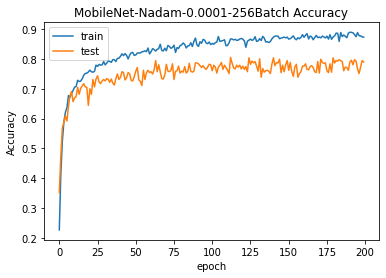

In [19]:
# summarize history for Accuracy
plt.plot(csv['accuracy'])
plt.plot(csv['val_accuracy'])
plt.title(f'{model_type} Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

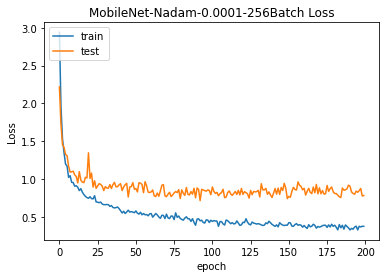

In [20]:
# summarize history for accuracy
plt.plot(csv['loss'])
plt.plot(csv['val_loss'])
plt.title(f'{model_type} Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()